# ICS 235 Homework Assignment 4

## Instructions

1. Name your notebook file using your last and first name as presented in Laulima.
    - For example, Kay, Baek ==> baek_kay_4.ipynb (The number at the end is the assignment number.)
2. Only use .ipynb file extensions. Other extensions (file formats) like .rtf, .zip, .docs, .pdf are not accepted.
3. Data files will be available to the instructor, so no need to upload them to Laulima. Make sure you use the same filenames of data files as given in the homework.
4. Save data files in **"data" folder under your working directory**. Use **relative path** when you read in data in your code.
5. Do not create any subfolders in your Drop Box.
6. Clean your code before submission.
    - If needed, provide clear documentation describing the purpose and how to use every class or function in your code.
    - Your submission should show only the required outputs. 
7. Run your code before submission to **show all outputs**. 
8. Do not modify the provided code unless intructed to do so.
9. Write your full name in the cell below.
***

## Your Name: Christian Dela Cruz
***

# Exercise 1: Lossy image compression using PCA  (40 points)

In this assignment, we will use Principal Component Analysis (PCA) to compress an image. Contrary to the example with MNIST dataset we saw in class, we have a single picture to compress. It means that we have a single sample, and n_pixels features. This is a problem if we want to efficiently represent our data with PCA. Our approach will therefore consider our image as a samples by features matrix, where each row of the image is a sample and the columns are features. Note that we could have chosen equivalently to do the contrary (samples as columns and features as rows).

In this assignment, we will refer to the "original space" the space of image, and the "PCA space" the space of image after PCA decomposition. The approach we are taking in this homework is to represent our image in the PCA space with a limited number of components. We want to select the smallest number of components that will preserve the image quality.

## Loading the data

We first need to load the image. One of the most common Python packages to process image is called PIL (Python Imaging Library). You don't need to learn how to use it, we will simply use it at the very beginning to convert our image into a numpy array.

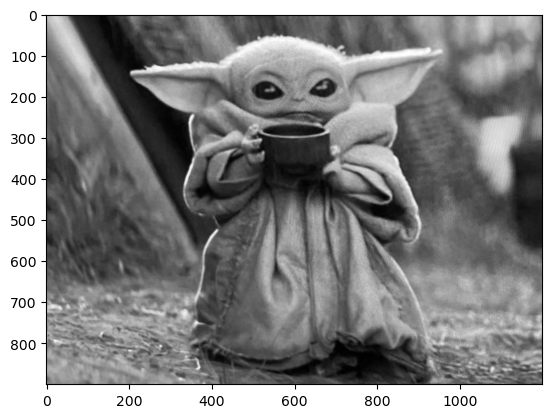

In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

img = Image.open("data/baby_yoda.jpeg", "r") # load the image
img = img.convert("L") # convert to grayscale

img_npy = np.array(img)

plt.imshow(img_npy, aspect="auto", cmap="gray")

1. 1. Run a Principal Components Analysis on the image with 50 components. (You don't need to scale the data.) (5 points)
   2. Display the explained variance in a plot, where the x-axis is the component ID and the y-axis is the **cumulative explained variance ratio** for the component. (5 points)
   3. How many components do you need to explain 90% of the data variance? 
   (For this question, you will need to write code to find the exact number, not manually by looking at the plot.) (5 points)

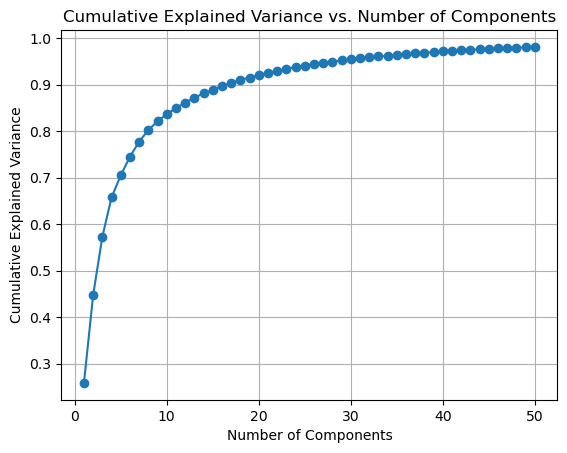

Number of components to explain 90% variance: 17


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

n_components = 50
pca = PCA(n_components=n_components)
pca_result = pca.fit_transform(img_npy)

explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

plt.plot(range(1, n_components + 1), cumulative_explained_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance vs. Number of Components')
plt.grid(True)
plt.show()

required_variance_ratio = 0.9
num_components_90 = np.argmax(cumulative_explained_variance >= required_variance_ratio) + 1

print(f"Number of components to explain 90% variance: {num_components_90}")



2. 1. Compute the compressed image (its PCA representation). (3 points)
   2. How much did we compress the image? Compute the ratio between the size of the compressed image and the original image. (2 points)
   3. Show the inverse transform of the compressed image. (5 points)

Compression ratio: 0.0417


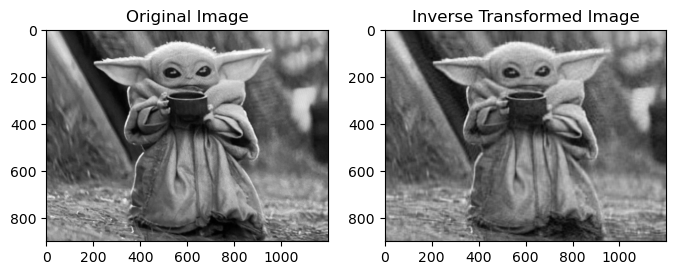

In [3]:
compressed_image = pca_result  

original_size = np.prod(img_npy.shape)
compressed_size = np.prod(compressed_image.shape)
compression_ratio = compressed_size / original_size

print(f"Compression ratio: {compression_ratio:.4f}")

inverse_transformed_image = pca.inverse_transform(compressed_image)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(np.reshape(img_npy, (900,1200)), cmap='gray')
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(np.reshape(inverse_transformed_image, (900, 1200)), cmap='gray')
plt.title('Inverse Transformed Image')

plt.show()



3. We want to visually inspect the compressed images to fine-tune the number of components. Evaluate the impact of the number of components on image quality by plotting in a single plot the original image and the results of compression for a varying number of components from 5 to 40 with a step of 5. Make 3 x 3 subplots to show the nine images. (15 points)
    - Each subplot should represent an image reconstructed from the compressed one for a given number of components. 
    - Place the original image in the first subplot.
    - Set the title of each subplot indicating the number of components used as well as the compression ratio as you computed in Question 2.B above.

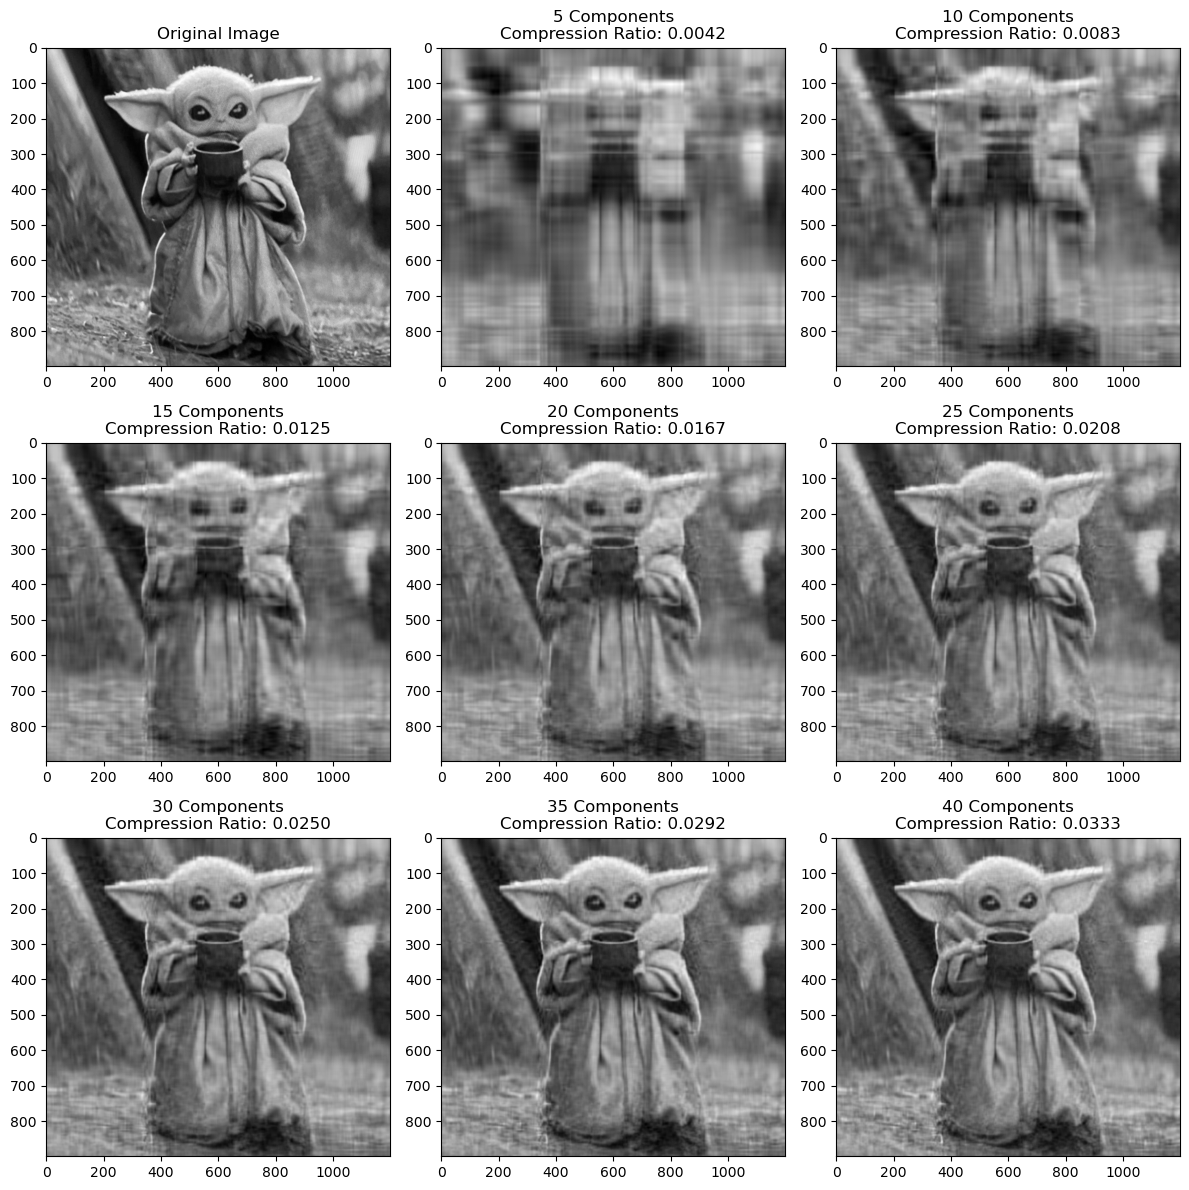

In [4]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

plt.figure(figsize=(12, 12))
plt.subplot(3, 3, 1)
plt.imshow(img_npy, aspect="auto", cmap="gray")
plt.title('Original Image')

for i, n_components in enumerate(range(5, 41, 5), start=2):
    pca = PCA(n_components=n_components)
    img_pca = pca.fit_transform(img_npy)

    original_size = np.prod(img_npy.shape)
    compressed_size = np.prod(img_pca.shape)
    compression_ratio = compressed_size / original_size

    img_reconstructed = pca.inverse_transform(img_pca)
    img_reconstructed = img_reconstructed.reshape(img_npy.shape)

    plt.subplot(3, 3, i)
    plt.imshow(img_reconstructed, aspect="auto", cmap="gray")
    plt.title(f'{n_components} Components\nCompression Ratio: {compression_ratio:.4f}')

plt.tight_layout()
plt.show()


# Exercise 2: Clustering  (60 points)

## About the data

In this exercise, we will work with a gene expression dataset from the Cancer Genome Atlas (TCGA) Research Network. Data was downloaded from the [UCI website](https://archive.ics.uci.edu/dataset/401/gene+expression+cancer+rna+seq).

Tumor samples were collected from patients with different types of cancer (breast, lung, kidney, ...) and the cells present in the tissues were sequenced. After some data processing, the sequencing data can be expressed in the form of a table, where the rows are our samples and the columns correspond to the number of times RNA from a given gene was detected (in other words, each column correspond to the expression level of a gene).

We want to answer two questions:

    - Can we distinguish between different cancer types by looking at the gene expression level of a tissue?
    - Can we identify the different types of samples if we don't know how many types of cancer we have in the dataset?
    
This problem has actually a direct application in the field of single-cell RNA sequencing. When collecting blood samples from cancer patients, we often have a mix of tumor cells and other cells (e.g. immune cells). Thus, if we want to study the differences between healthy and tumor cells, it is important to sort through those.

## Loading the data

Note: Due to the size limit of 100MB per upload to Laulima, "tcga.csv" file was zipped to "tcga.zip". You should unzip the file before proceeding.

In [5]:
import pandas as pd

df = pd.read_csv("data/tcga.csv", index_col=0, low_memory=False)
df.head()

,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,gene_9,...,gene_20521,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530
sample_0,0.0,2.017209,3.265527,5.478487,10.431999,0.0,7.175175,0.591871,0.0,0.0,...,4.926711,8.210257,9.723516,7.220030,9.119813,12.003135,9.650743,8.921326,5.286759,0.0
sample_1,0.0,0.592732,1.588421,7.586157,9.623011,0.0,6.816049,0.000000,0.0,0.0,...,4.593372,7.323865,9.740931,6.256586,8.381612,12.674552,10.517059,9.397854,2.094168,0.0
sample_2,0.0,3.511759,4.327199,6.881787,9.870730,0.0,6.972130,0.452595,0.0,0.0,...,5.125213,8.127123,10.908640,5.401607,9.911597,9.045255,9.788359,10.090470,1.683023,0.0
sample_3,0.0,3.663618,4.507649,6.659068,10.196184,0.0,7.843375,0.434882,0.0,0.0,...,6.076566,8.792959,10.141520,8.942805,9.601208,11.392682,9.694814,9.684365,3.292001,0.0
sample_4,0.0,2.655741,2.821547,6.539454,9.738265,0.0,6.566967,0.360982,0.0,0.0,...,5.996032,8.891425,10.373790,7.181162,9.846910,11.922439,9.217749,9.461191,5.110372,0.0


Variance explained by the first 2 components: 26.34%


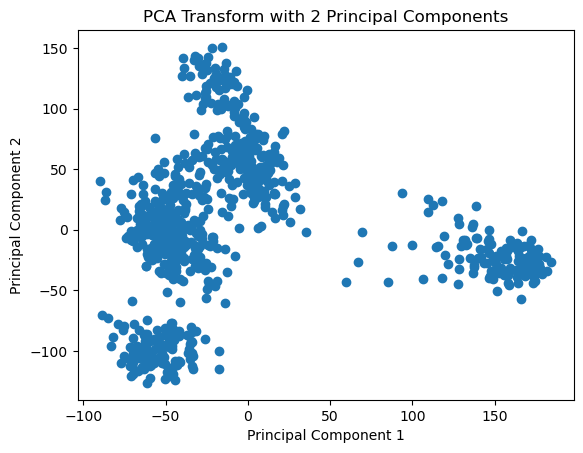

In [6]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

n_components = 2
pca = PCA(n_components=n_components)
transformed_data = pca.fit_transform(df)

explained_variance_ratio = pca.explained_variance_ratio_
print(f"Variance explained by the first 2 components: {explained_variance_ratio.sum() * 100:.2f}%")

plt.scatter(transformed_data[:, 0], transformed_data[:, 1])
plt.title('PCA Transform with 2 Principal Components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


2. What are the pros and cons of clustering the points in the PCA space rather than the original space? Give one reason for each. (6 points)

> **Your answer**:
>PROS:
> Dimensionality Reduction: clustering in the PCA reduces the dimensionality of the dataset which makes it easier to focus on the informative components and can lead to faster and more efficient clustering algorithms, especially when dealing with higher dimensional datasets.
>CONS:
> Loss of Interpretability: Clustering in the PCA space may result in clusters that are not directly interpretable in the original feature space. While PCA captures the most significant variations, the transformed features might not have clear  meanings, making it challenging to interpret the clusters in the context of the original features.

3. 1. Cluster the points in the PCA space using the K-means clustering algorithm. Choose the value for K you think is the best. (5 points)
   2. Re-do the scatter plot from Question 1.C and color the points according to the assigned clusters. (3 points)

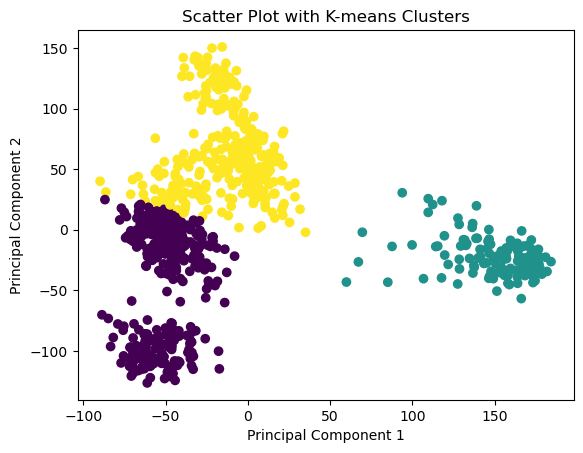

In [7]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=42, n_init = 10)
clusters = kmeans.fit_predict(transformed_data)

# Plot the scatter plot with colored clusters
plt.scatter(transformed_data[:, 0], transformed_data[:, 1], c=clusters, cmap='viridis', marker='o')
plt.title('Scatter Plot with K-means Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()



4. 1. We want to find the best K for this clustering problem by looking at the inertia. Plot the inertia as a function of K for K from 2 to 10 (step = 1). (8 points)
   2. What would be the ideal number of clusters? Explain. (6 points)

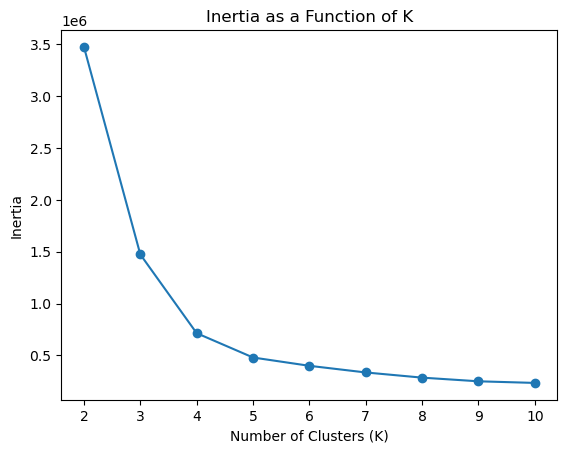

In [8]:
from sklearn.cluster import KMeans

inertia_values = []
k_values = range(2, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init = 10)
    kmeans.fit(transformed_data)
    inertia_values.append(kmeans.inertia_)

plt.plot(k_values, inertia_values, marker='o')
plt.title('Inertia as a Function of K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.show()


>**Your answer (4.B)**: 
>The ideal number of clusters based on the graph using the elbow method would be 5 because as the number of K clusters increases, the inertia starts decreasing at a less significant rate as increasing clusters after that point may not improve in reducing inertia.

5. One advantage of DBSCAN is that it doesn't require a number of clusters. Instead, it uses other hyperparameters that will indirectly control for it. 
    1. Describe the two main hyperparameters of DBSCAN and their impact on clustering. (7 points)
    2. Cluster the points (in the PCA space) with DBSCAN, and select the values for the two main hyperparameters that will provide between 3 and 6 clusters. (6 points)
    3. Re-do the scatter plot from Question 1.C and color the points using the DBSCAN clusters. (2 points)

> **Your answer (5.A)**:
> EPSILON: defines the neighborhoods radius within where the algorithm searches for neighboring points. Depending on how big or small epsilon is affects the density of the clusters, meaning if epsilon is too small, it could lead to over-segmentation, while a larger epsilon could lead into merging distinct clusters.
> MIN_SAMPLES: determines the minimum amount of samples that must be in the radius (epsilon) for it to become a core-point and to become a cluster. This affects how large or small a cluster may be and how sensitive the algorithm is to outliers. 

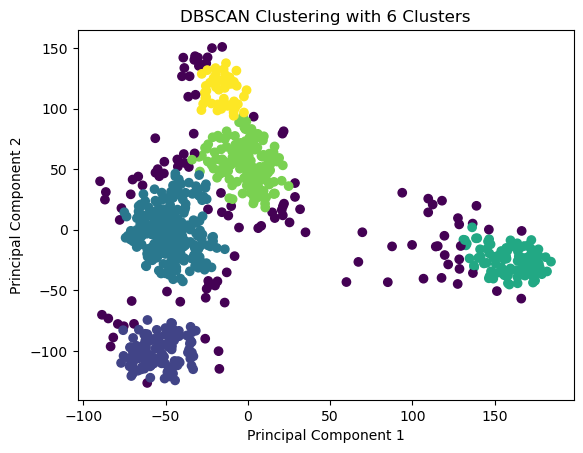

In [9]:
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

epsilon = 10  
min_points = 12

dbscan = DBSCAN(eps=epsilon, min_samples=min_points)
db_clusters = dbscan.fit_predict(transformed_data)

# Re-do scatter plot with colored DBSCAN clusters
plt.scatter(transformed_data[:, 0], transformed_data[:, 1], c=db_clusters, cmap='viridis', marker='o')
plt.title(f'DBSCAN Clustering with {len(set(db_clusters))} Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


We found the true labels for this dataset. Let's first load them into the "true_labels" variable.

In [10]:
true_labels = pd.read_csv("data/tcga_labels.csv", index_col=0).Class

6. We want to compare the clustering results from K-means with the best K and for the true labels. 
    1. Redo the plot from Question 3, but color the points with the true labels and add a legend with the true class labels. (3 points)
    2. How can you evaluate the effectiveness of K-means clustering to retrieve the true labels? Review the scikit-learn's metrics module for measuring the similarity between two clusterings (the predicted and true clusterings), and briefly explain the approach. (There are multiple possible answers.) (6 points)

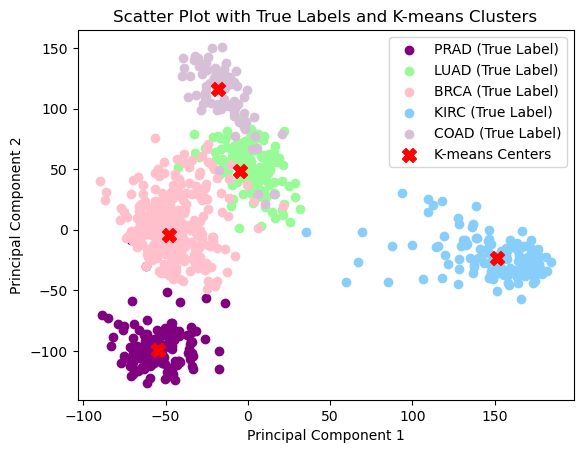

In [11]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
true_labels_encoded = label_encoder.fit_transform(true_labels)

kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
kmeans_clusters = kmeans.fit_predict(transformed_data)

class_colors = {'BRCA': 'pink', 'KIRC': 'lightskyblue', 'LUAD': 'palegreen', 'PRAD': 'purple', 'COAD': 'thistle'}

for class_label in true_labels.unique():
    indices = true_labels == class_label
    plt.scatter(
        transformed_data[indices, 0],
        transformed_data[indices, 1],
        label=f'{class_label} (True Label)',
        color=class_colors[class_label]
    )

plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='X', label='K-means Centers', s=100)
plt.title('Scatter Plot with True Labels and K-means Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()


> **Your answer (6.B)**: 
>To evaluate the effectiveness of K-means clustering to retrieve true labels, you'll need different metrics that are able to measure the agreement between the predicted and true class labels. One of these metrics from scikit learn is the ARI (Adjusted Rand Index) where it compares two clusterings by adjusting for chance. It does this by measuring all pairs of samples on how often they are placed in the same or different clusters in both the true and predicited clusterings. A higher value means that there is a better similarity between the two clusterings. 